In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 15.98 MiB/s, done.
Updating files: 100% (12939/12939), done.


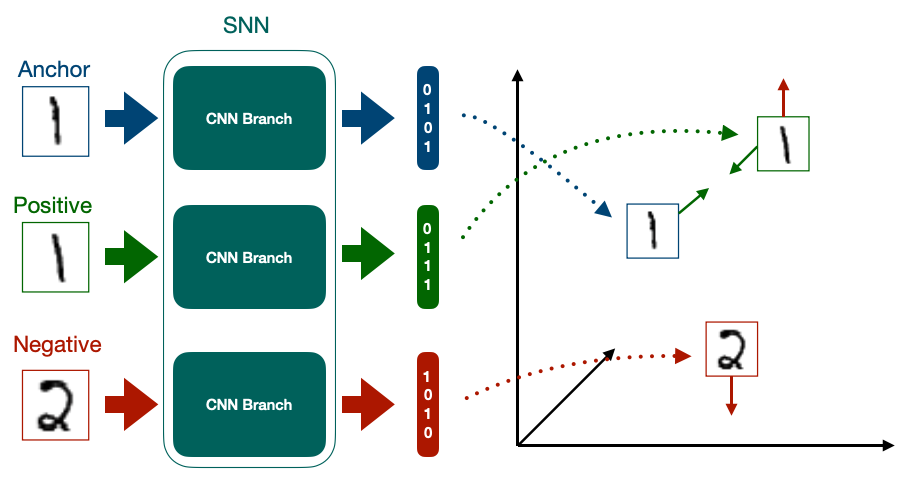

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
data_dir='/content/Person-Re-Id-Dataset/train/'
csv_file='/content/Person-Re-Id-Dataset/train.csv'

batch_size=32
learning_rate=0.001
epochs=15

device='cuda'

In [6]:
df=pd.read_csv(csv_file)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row=df.iloc[6]

anchor_image=io.imread(data_dir + row.Anchor)
positive_image=io.imread(data_dir + row.Positive)
negative_image=io.imread(data_dir + row.Negative)


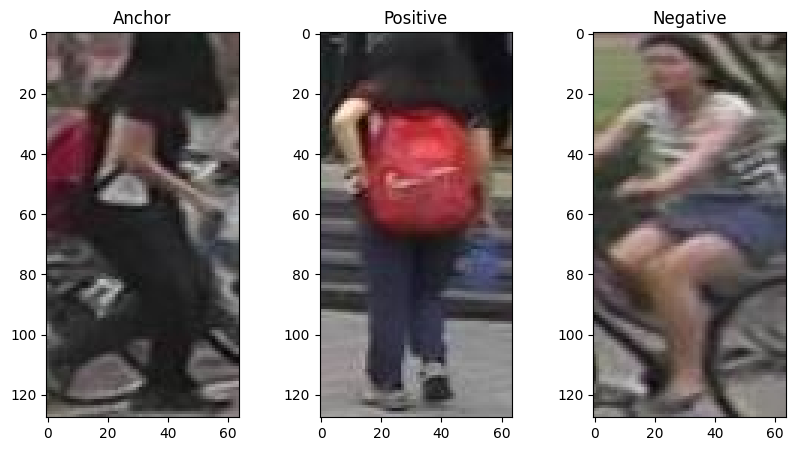

In [8]:
f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))

ax1.set_title('Anchor')
ax1.imshow(anchor_image)

ax2.set_title('Positive')
ax2.imshow(positive_image)

ax3.set_title('Negative')
ax3.imshow(negative_image)

In [9]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Create APN Dataset

In [10]:
class APN_Dataset(Dataset):
  def __init__(self,df):
    self.df=df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row=self.df.iloc[index]

    anchor_image=io.imread(data_dir + row.Anchor)
    positive_image=io.imread(data_dir + row.Positive)
    negative_image=io.imread(data_dir + row.Negative)

    anchor_image=torch.from_numpy(anchor_image).permute(2,0,1)/255.0
    positive_image=torch.from_numpy(positive_image).permute(2,0,1)/255.0
    negative_image=torch.from_numpy(negative_image).permute(2,0,1)/255.0

    return anchor_image,positive_image,negative_image

In [12]:
trainset=APN_Dataset(train_df)
validset=APN_Dataset(valid_df)

print(f"Length of trainset : {len(trainset)}")
print(f"Length of validset : {len(validset)}")

Length of trainset : 3200
Length of validset : 800


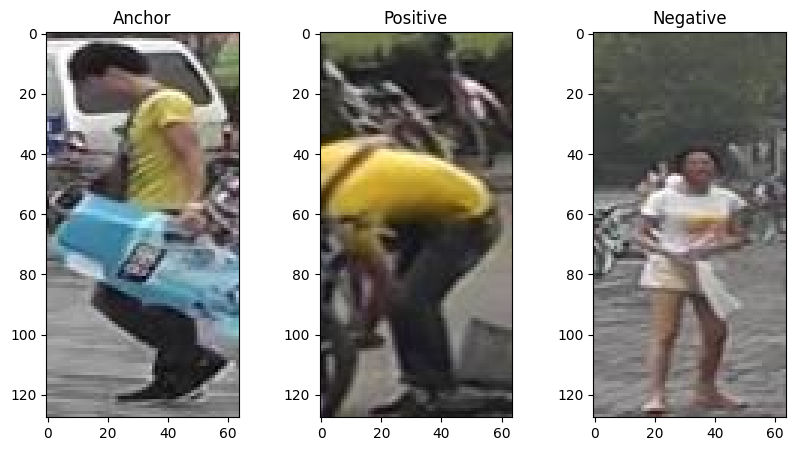

In [13]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [14]:
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader=DataLoader(validset,batch_size=batch_size,shuffle=False)

In [15]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [16]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [17]:
class APN_Model(nn.Module):

  def __init__(self, emb_size=512):
    super(APN_Model,self).__init__()

    self.efficientnet=timm.create_model('efficientnet_b0',pretrained=True)
    self.efficientnet.classifier =nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self,images):
    embeddings=self.efficientnet(images)

    return embeddings




In [18]:
model=APN_Model()
model.to(device);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Create Train and Eval function

In [19]:
def train_fn(model,data_loader,optimizer,criterion):
  model.train() #ON Dropout
  total_loss=0.0

  for A,P,N in tqdm(data_loader):
    A=A.to(device)
    P=P.to(device)
    N=N.to(device)

    A_embs=model(A)
    P_embs=model(P)
    N_embs=model(N)

    loss=criterion(A_embs,P_embs,N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)

In [20]:
def eval_fn(model,data_loader,criterion):
  model.eval() #OFF Dropout
  total_loss=0.0

  with torch.no_grad():

    for A,P,N in tqdm(data_loader):
      A=A.to(device)
      P=P.to(device)
      N=N.to(device)

      A_embs=model(A)
      P_embs=model(P)
      N_embs=model(N)

      loss=criterion(A_embs,P_embs,N_embs)

      total_loss+=loss.item()

    return total_loss/len(data_loader)

In [21]:
criterion=nn.TripletMarginLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

# Create Training Loop

In [22]:
best_valid_loss=np.inf

for i in range(epochs):
  train_loss=train_fn(model,trainloader,optimizer,criterion)
  valid_loss=eval_fn(model,validloader,criterion)



  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    best_valid_loss=valid_loss

    print("SAVED WEIGHTS SUCCESS")

    print(f"Epoch : {i+1}")
    print(f"Train Loss : {train_loss}")
    print(f"Valid Loss : {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  8.04it/s]


SAVED WEIGHTS SUCCESS
Epoch : 1
Train Loss : 0.5673476803302765
Valid Loss : 0.5425589358806611


100%|██████████| 25/25 [00:03<00:00,  8.29it/s]


SAVED WEIGHTS SUCCESS
Epoch : 2
Train Loss : 0.28555128872394564
Valid Loss : 0.3061067795753479


100%|██████████| 25/25 [00:03<00:00,  8.28it/s]


SAVED WEIGHTS SUCCESS
Epoch : 3
Train Loss : 0.15346025615930559
Valid Loss : 0.2561026471853256


100%|██████████| 25/25 [00:02<00:00,  8.39it/s]


SAVED WEIGHTS SUCCESS
Epoch : 4
Train Loss : 0.09246350437402726
Valid Loss : 0.20592845618724823


100%|██████████| 25/25 [00:02<00:00,  8.37it/s]


SAVED WEIGHTS SUCCESS
Epoch : 5
Train Loss : 0.07875225283205509
Valid Loss : 0.20381210029125213


100%|██████████| 25/25 [00:03<00:00,  8.27it/s]


SAVED WEIGHTS SUCCESS
Epoch : 6
Train Loss : 0.0584166244417429
Valid Loss : 0.1879257947206497


100%|██████████| 25/25 [00:02<00:00,  8.35it/s]


SAVED WEIGHTS SUCCESS
Epoch : 7
Train Loss : 0.05040433883666992
Valid Loss : 0.12072891592979432


100%|██████████| 25/25 [00:03<00:00,  8.33it/s]


# Get Anchor Embeddings

In [23]:
def get_encoding_csv(model,anc_img_names):
  anc_img_names_arr=np.array(anc_img_names)
  encodings=[]

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A=io.imread(data_dir + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A=A.to(device)
      A_enc=model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings=np.array(encodings)
    encodings=pd.DataFrame(encodings)
    df_enc=pd.concat([anc_img_names,encodings],axis=1)

    return df_enc


In [24]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc=get_encoding_csv(model,df['Anchor'])

100%|██████████| 4000/4000 [00:44<00:00, 90.22it/s]


In [25]:
df_enc.to_csv('database.csv',index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.105013,0.794796,-0.799210,0.257987,0.246629,0.822533,-0.417378,-0.412765,-0.126642,...,0.276028,0.898298,-0.190189,-0.398096,-0.033841,0.039883,0.142248,-0.147700,-0.025481,-0.150732
1,1420_c3s3_061978_03.jpg,-0.225268,0.630829,-0.761729,0.072160,0.114085,0.746094,-0.236289,-0.530238,-0.622477,...,0.292732,0.401876,-0.191672,-0.218335,-0.140078,-0.097256,0.493468,-0.615364,0.183550,0.286619
2,1420_c5s3_062565_05.jpg,-0.193980,0.584619,-0.869936,0.072741,0.441314,0.875002,-0.433075,-0.410051,-0.657459,...,0.095511,1.075457,-0.220060,-0.613278,-0.159975,-0.071746,0.150765,-0.616656,0.102115,0.102750
3,1420_c6s3_085592_04.jpg,-0.131508,0.952465,-0.354148,0.460350,-0.266041,0.577294,-0.225687,-0.067805,-0.239329,...,0.265842,0.942365,0.712664,-0.152084,-0.247421,0.113998,-0.014944,0.066064,-0.057547,-0.311603
4,0663_c5s3_085987_03.jpg,-0.582001,0.425918,-0.840427,-0.396705,-0.242967,0.437363,0.600681,0.285527,0.118714,...,0.810139,0.504927,0.540839,-0.044965,0.189445,-0.346482,-0.030347,0.566396,0.237580,-0.313457


# Inference

In [26]:
def eucledian_dist(img_enc,anc_enc_arr):
  dist=np.sqrt(np.dot(img_enc-anc_enc_arr,(img_enc-anc_enc_arr).T))
  return dist


In [38]:
idx=108
img_name=df_enc['Anchor'].iloc[idx]
img_path=data_dir + img_name
img=io.imread(img_path)
img =torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
  img=img.to(device)
  img_enc=model(img.unsqueeze(0))
  img_enc=img_enc.cpu().detach().numpy()

In [39]:
anc_enc_arr=df_enc.iloc[:,1:].values
anc_img_names=df_enc['Anchor']

In [40]:
distance=[]

for i in range(anc_enc_arr.shape[0]):
  dist=eucledian_dist(img_enc,anc_enc_arr[i : i+1, :])
  distance=np.append(distance,dist)


In [41]:
closest_idx=np.argsort(distance)

/usr/local/lib/python3.11/dist-packages/networkx/drawing/layout.py:728: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


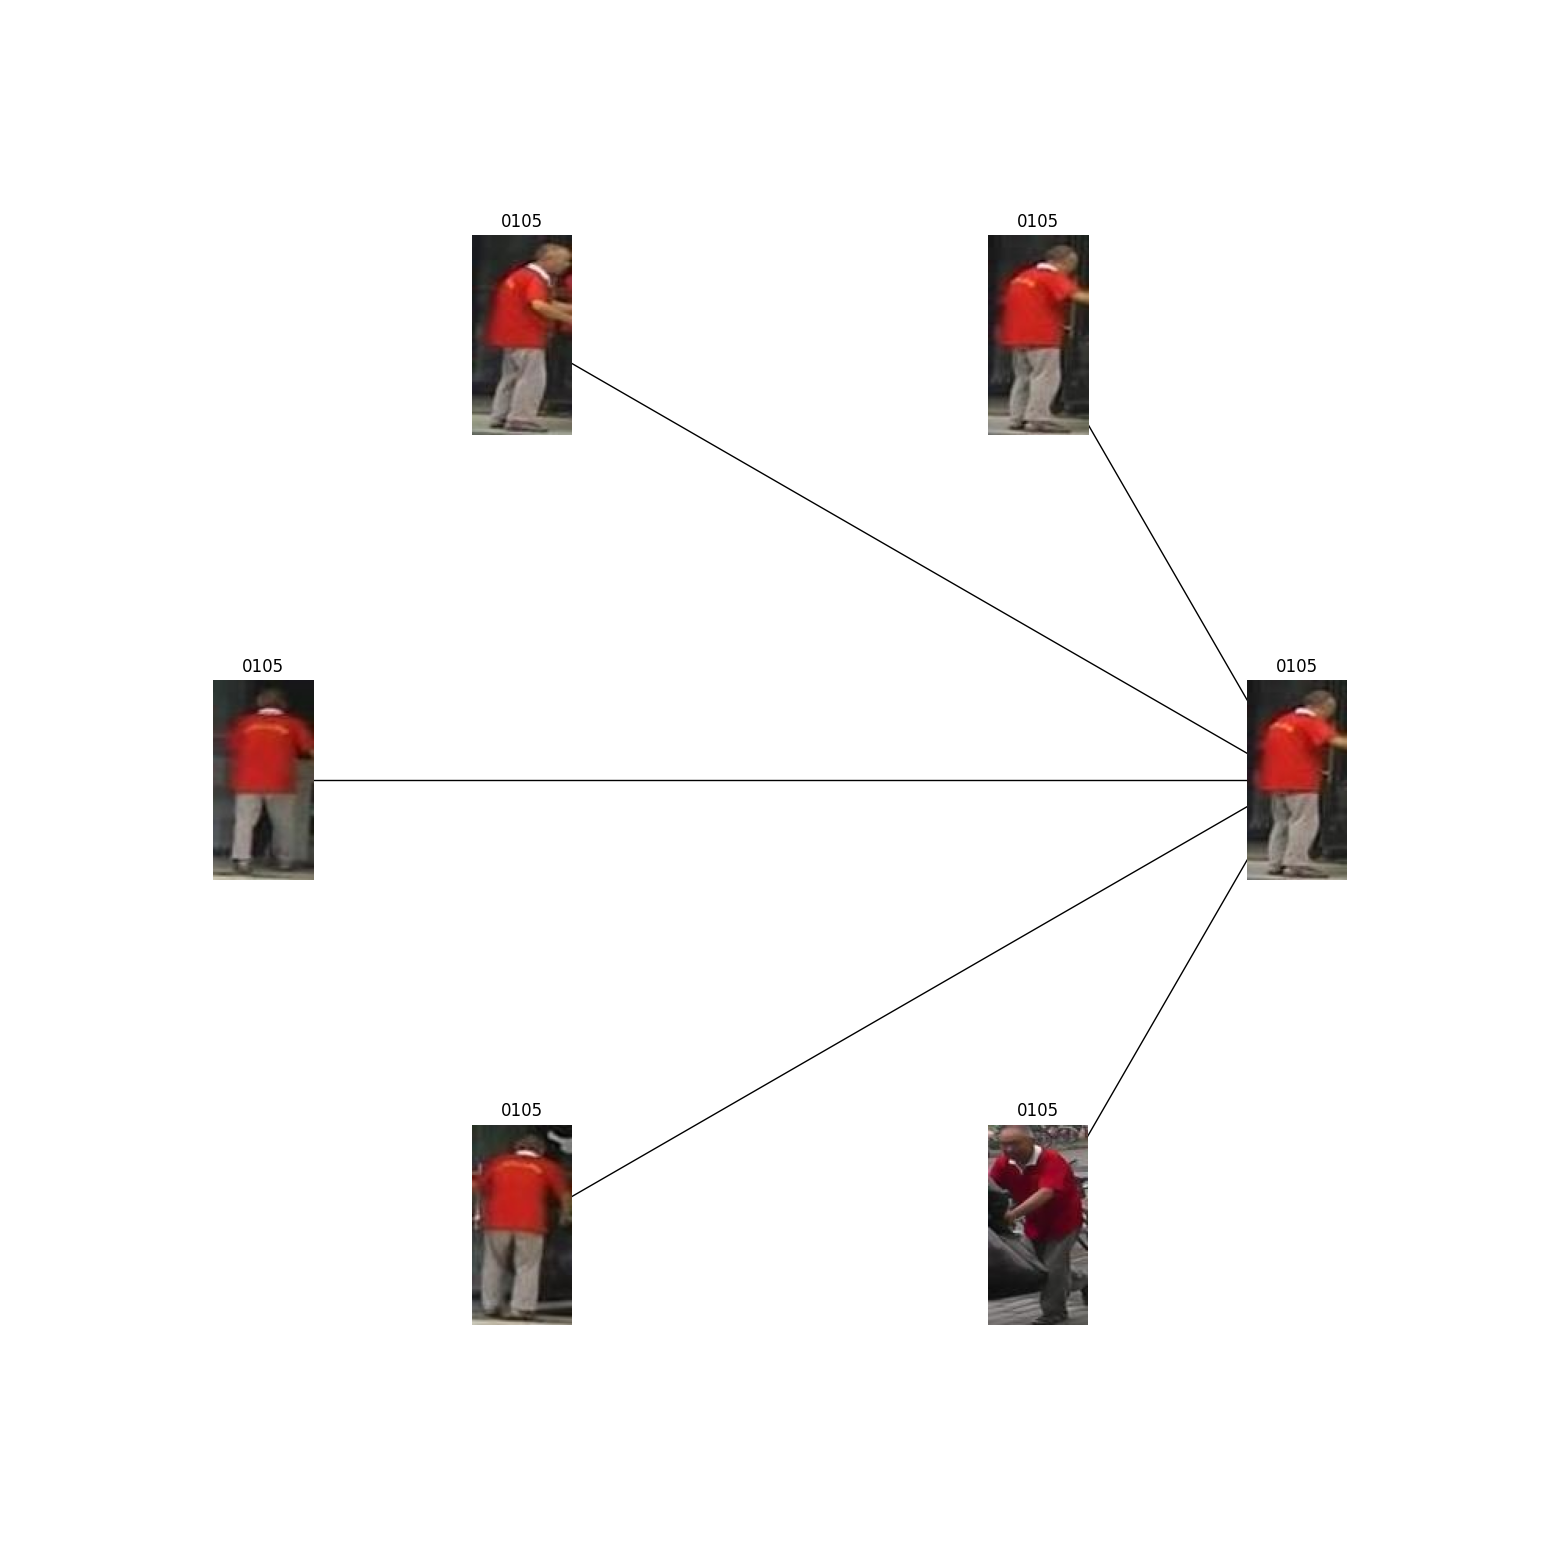

In [42]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, data_dir, img, img_path, closest_idx, distance, no_of_closest = 5);